In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_vae import LSTM_VAE
from utils.data import load_df, load_df_with_names, load_df_by_names
from utils.metrics import f1_score, far, mar

from typing import Dict



In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
# redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Pressure','Temperature', 'Thermocouple' ]
redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Thermocouple' ]

In [4]:
df_train = pd.read_csv("./data/valve1/6.csv", sep=";", parse_dates=True, index_col="datetime")
df_train.sort_index(inplace=True)

first_anomaly_idx = df_train.index.get_loc(df_train[df_train["anomaly"] == 1].index[0])
df_train = df_train.drop(redundant_features, axis=1)
train_size = int(first_anomaly_idx * 0.9)
train_size

518

In [5]:
x_train = df_train[:train_size]
x_train.head(3)

,Pressure,Temperature,Volume Flow RateRMS
datetime,,,
2020-03-09 12:14:36,0.382638,71.2129,32.0000
2020-03-09 12:14:37,0.710565,71.4284,32.0104
2020-03-09 12:14:38,0.054711,71.3468,32.0000


In [6]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
class Config:
    TIME_STEPS = 50
    epochs = 10
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_VAE_2ndPredictor:
    def fit(self, df_train):
        ss = StandardScaler()
        self.ss = ss
        x_train = df_train[:train_size]
        x_train = np.array(ss.fit_transform(x_train))
        x_train = create_sequences(x_train, conf.TIME_STEPS)

        self.model = LSTM_VAE(optimizer=optimizer)
        self.model.fit(x_train, epochs=conf.epochs, batch_size=conf.batch_size)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            x_test = np.array(self.ss.transform(df))
            x_test = create_sequences(x_test, conf.TIME_STEPS)
            r = pd.Series(np.sum(np.mean(np.abs(self.model.predict(x_test) - x_test), axis=1), axis=1)) 
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            a = smoothed#.diff(10).abs()
            
            IQR = a.quantile(0.75) - a.quantile(0.75)
            UCL = a.quantile(0.75) + 1.5 * IQR
            
            # plt.plot(a)
            # plt.axhline(UCL, color='r')
            # plt.show()
            
            s = a > UCL
            w = 10
            is_anomaly = s.rolling(window = w).mean().fillna(s.iloc[0])
            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0]) #+ conf.TIME_STEPS - 1

            prediction = pd.Series(data=0, index=df.index)
            prediction.iloc[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions
    

In [7]:
%%time
predictor = LSTM_VAE_2ndPredictor()
predictor.fit(df_train)


Epoch 1/10
47/47 [==============================] - 10s 91ms/step - loss: 0.8546
Epoch 2/10
47/47 [==============================] - 4s 86ms/step - loss: 0.7224
Epoch 3/10
47/47 [==============================] - 5s 105ms/step - loss: 0.7152
Epoch 4/10
47/47 [==============================] - 5s 101ms/step - loss: 0.7079
Epoch 5/10
47/47 [==============================] - 4s 92ms/step - loss: 0.7020
Epoch 6/10
47/47 [==============================] - 5s 106ms/step - loss: 0.6980
Epoch 7/10
47/47 [==============================] - 6s 119ms/step - loss: 0.6954
Epoch 8/10
47/47 [==============================] - 6s 126ms/step - loss: 0.6935
Epoch 9/10
47/47 [==============================] - 4s 86ms/step - loss: 0.6909
Epoch 10/10
47/47 [==============================] - 4s 85ms/step - loss: 0.6888
CPU times: total: 2min 23s
Wall time: 53.2 s


In [8]:
%%time
df_by_names = load_df_by_names("./data/", ["valve1", "valve2"])
# df_by_names = load_df_by_names("./data/", ["valve2"])
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = predictor.predict(df_by_names)

CPU times: total: 1min 38s
Wall time: 37.6 s


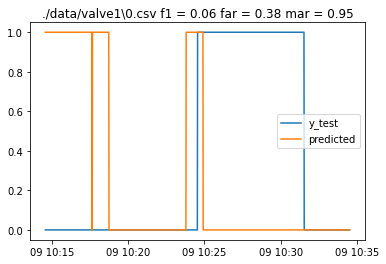

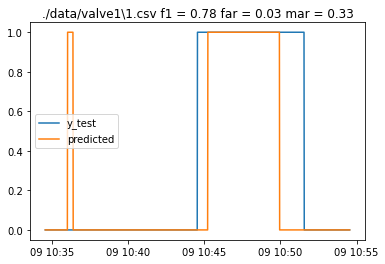

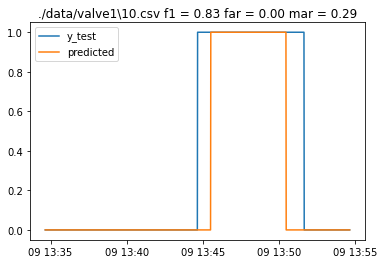

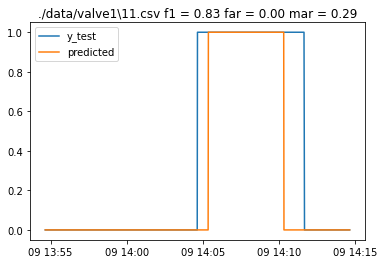

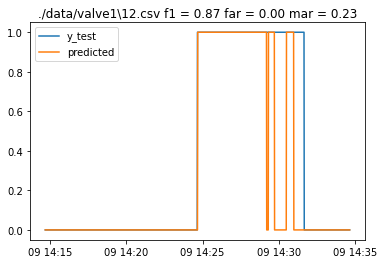

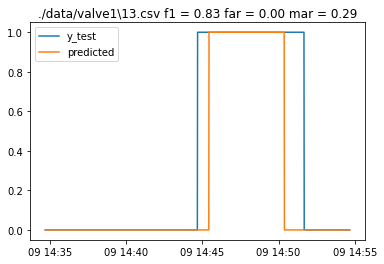

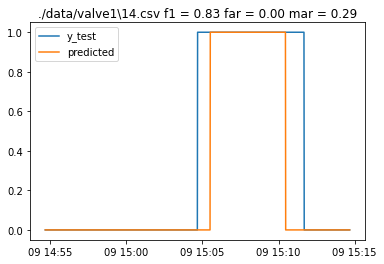

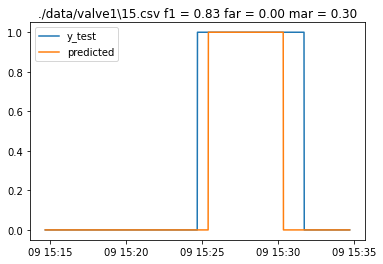

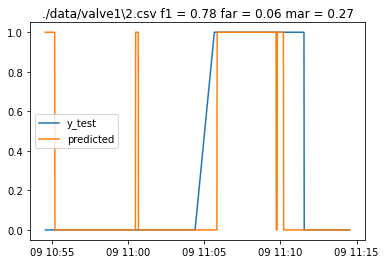

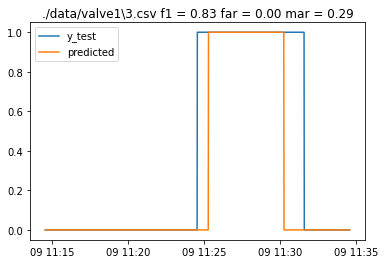

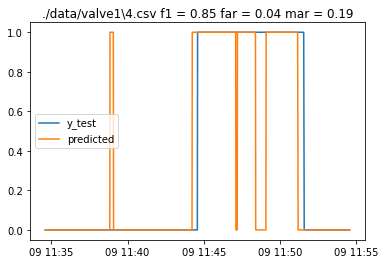

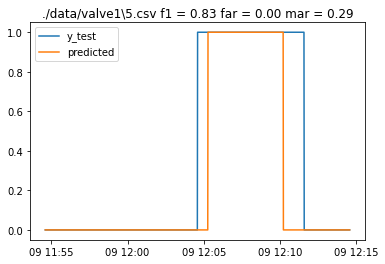

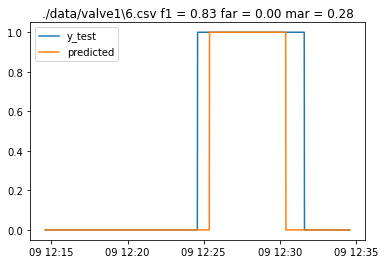

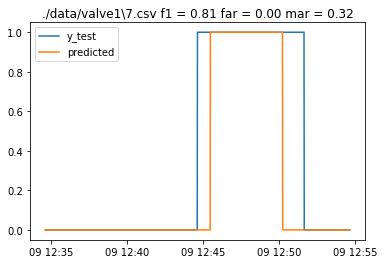

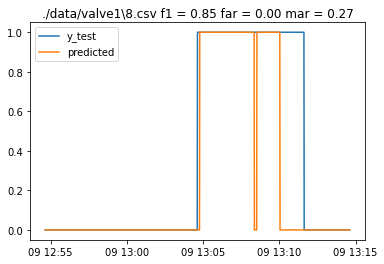

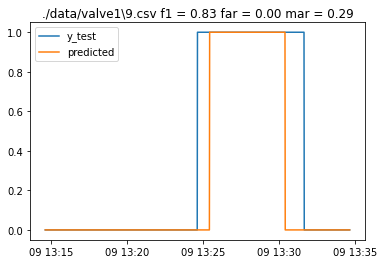

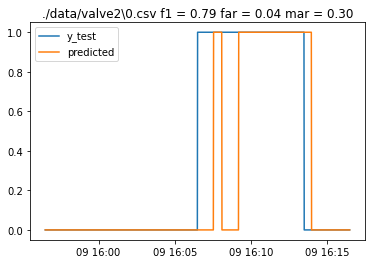

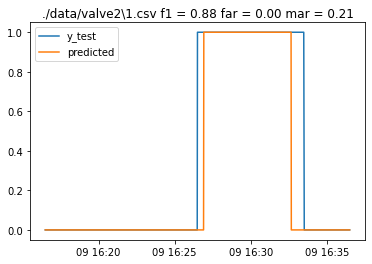

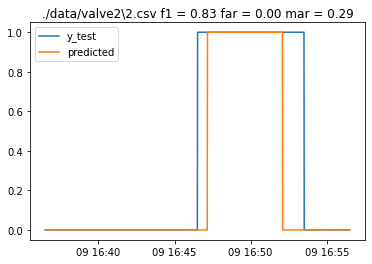

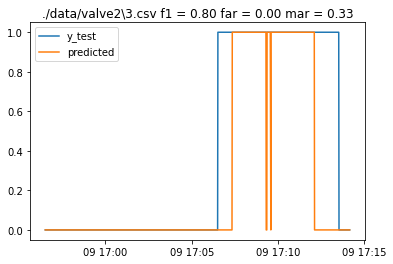

In [9]:

metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [10]:
from utils.data import show_score_table

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.06 | 0.78 | 0.83 | 0.83 | 0.87 | 0.83 | 0.83 | 0.83 | 0.78 | 0.83 | 0.85 | 0.83 | 0.83 | 0.81 | 0.85 | 0.83 | 0.79 | 0.88 | 0.83 | 0.8
FAR |0.38 | 0.03 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.06 | 0.0 | 0.04 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.04 | 0.0 | 0.0 | 0.0
MAR |0.95 | 0.33 | 0.29 | 0.29 | 0.23 | 0.29 | 0.29 | 0.3 | 0.27 | 0.29 | 0.19 | 0.29 | 0.28 | 0.32 | 0.27 | 0.29 | 0.3 | 0.21 | 0.29 | 0.33

metric | valve1 | valve2
--- | --- | ---
F1 |0.78 | 0.82
FAR |0.03 | 0.01
MAR |0.33 | 0.29

### SKAB


In [11]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np

from scipy.signal import medfilt

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [12]:
# libraries importing
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [13]:
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        mse = losses.MeanSquaredError()
        xent_loss = mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae, encoder, generator

In [14]:
def arch(data):
    input_dim = data.shape[-1] # 13
    timesteps = data.shape[1] # 3
    BATCH_SIZE = 1
    
    model, enc, gen = create_lstm_vae(input_dim, 
        timesteps=timesteps, 
        batch_size=BATCH_SIZE, 
        intermediate_dim=32,
        latent_dim=100,
        epsilon_std=1.)

    history = model.fit(
        data,
        data,
        epochs=20,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        ],
    )
    return history, model

In [15]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
class Config:
    TIME_STEPS = 50
    epochs = 10
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_VAE_SKAB_Predictor:
    def fit(self, df_train):
        ss = StandardScaler()
        self.ss = ss
        x_train = df_train[:train_size]
        x_train = np.array(ss.fit_transform(x_train))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        _, model = arch(x_train)# ~ fit
        self.model = model
        
        healthy_r = pd.Series(np.sum(np.mean(np.abs(self.model.predict(x_train) - x_train), axis=1), axis=1)) 
        self.UCL = healthy_r.quantile(conf.Q)
            
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            x_test = np.array(self.ss.transform(df))
            x_test = create_sequences(x_test, conf.TIME_STEPS)
            r = pd.Series(np.sum(np.mean(np.abs(self.model.predict(x_test) - x_test), axis=1), axis=1)) 
            
            smoothed = r.rolling(window = 10).mean().fillna(r.iloc[0])
            a = smoothed.diff(10).abs()
            
            IQR = a.quantile(0.75) - a.quantile(0.75)
            UCL = a.quantile(0.75) + 1.5 * IQR
            
            s = a > UCL
            w = 10
            is_anomaly = s.rolling(window = w).mean().fillna(s.iloc[0])
            anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0]) #+ conf.TIME_STEPS - 1

            prediction = pd.Series(data=0, index=df.index)
            prediction.iloc[anomalous_data_indices] = 1
            predictions[file_name] = prediction
            
        return predictions
    

In [16]:
%%time
skab_predictor = LSTM_VAE_SKAB_Predictor()
skab_predictor.fit(df_train)

CPU times: total: 6min 49s
Wall time: 2min 21s


In [17]:
%%time
predictions_by_names = skab_predictor.predict(df_by_names)

CPU times: total: 33.6 s
Wall time: 13 s


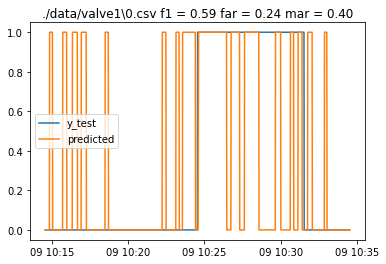

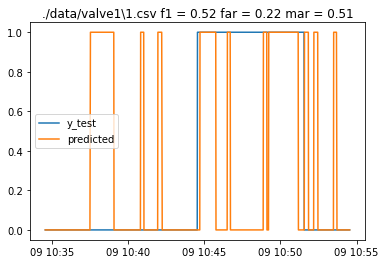

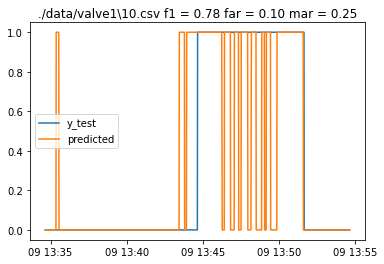

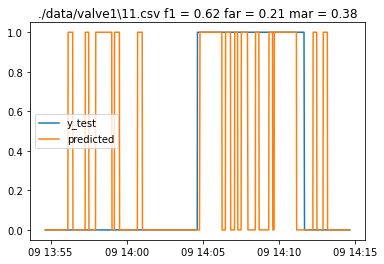

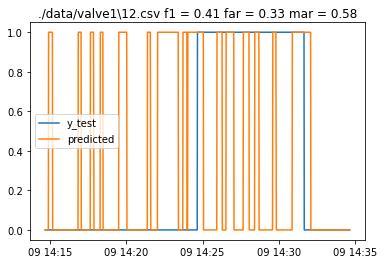

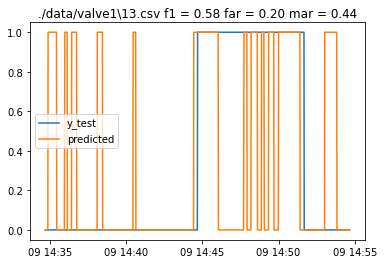

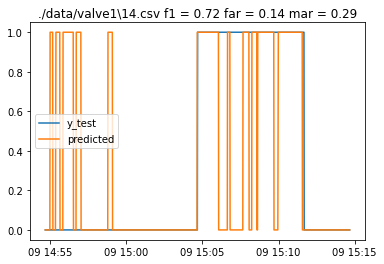

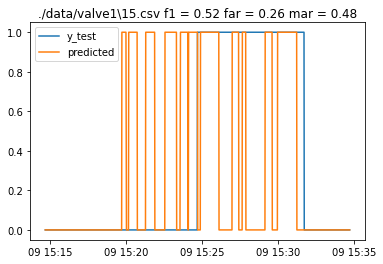

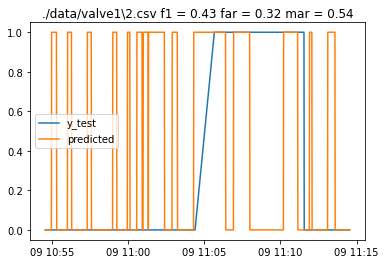

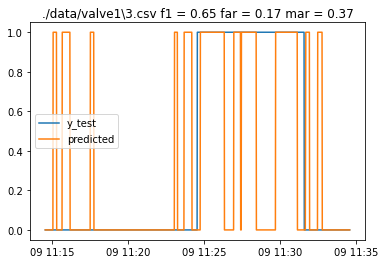

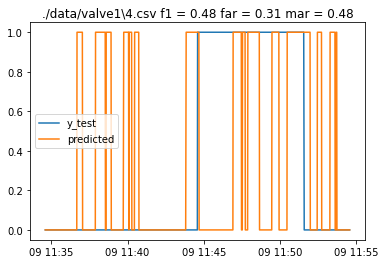

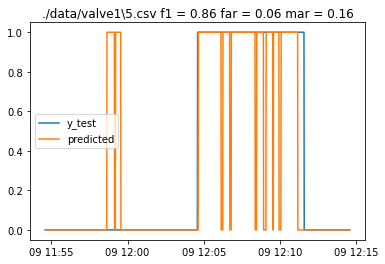

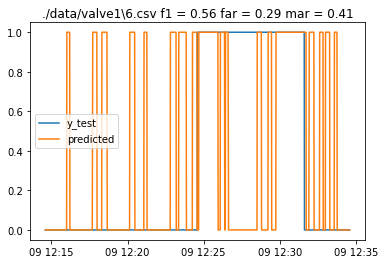

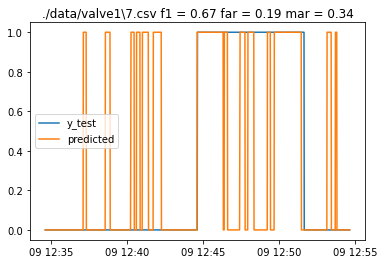

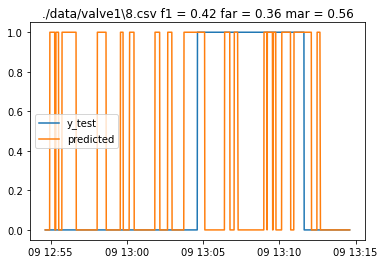

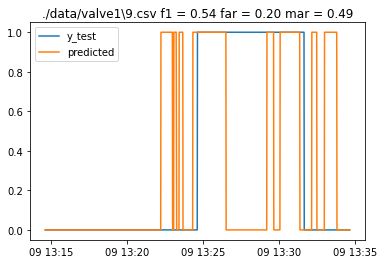

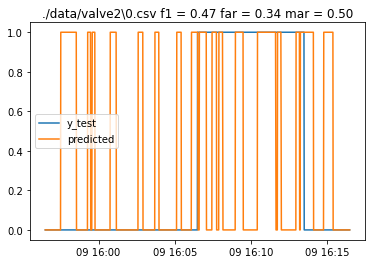

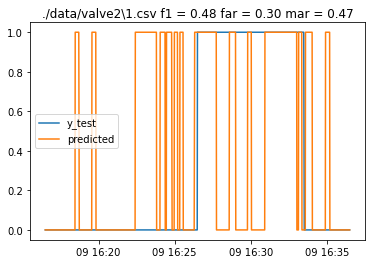

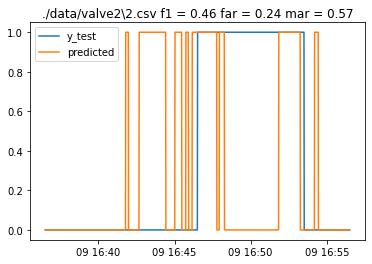

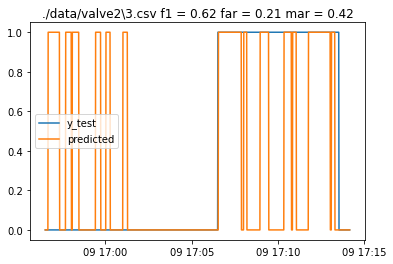

In [18]:

metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [19]:
from utils.data import show_score_table

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.59 | 0.52 | 0.78 | 0.62 | 0.41 | 0.58 | 0.72 | 0.52 | 0.43 | 0.65 | 0.48 | 0.86 | 0.56 | 0.67 | 0.42 | 0.54 | 0.47 | 0.48 | 0.46 | 0.62
FAR |0.24 | 0.22 | 0.1 | 0.21 | 0.33 | 0.2 | 0.14 | 0.26 | 0.32 | 0.17 | 0.31 | 0.06 | 0.29 | 0.19 | 0.36 | 0.2 | 0.34 | 0.3 | 0.24 | 0.21
MAR |0.4 | 0.51 | 0.25 | 0.38 | 0.58 | 0.44 | 0.29 | 0.48 | 0.54 | 0.37 | 0.48 | 0.16 | 0.41 | 0.34 | 0.56 | 0.49 | 0.5 | 0.47 | 0.57 | 0.42

metric | valve1 | valve2
--- | --- | ---
F1 |0.58 | 0.51
FAR |0.23 | 0.28
MAR |0.41 | 0.49